# Planetary Data Analysis Notebook

For the first part of this script, I will solely focus on the kNN supervised learning technique applied to the data pertaining to exoplanets from NASA.

In [1]:
# Import necessary libraries
from random import seed
from random import randrange
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from  sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from math import sqrt
#import plotly.express as px

In [2]:
# Assign path of data to a variable.
# Initiate first data frame with raw data.
seed(11)
path = 'https://raw.githubusercontent.com/jbravo87/blog-projects/main/data/PS_2022.05.10_21.48.38.csv'
raw_data = pd.read_csv(path, skiprows = 12)

Need to remove the first twelve rows. These rows contain copious notes/remarks. Want to see the head and tail of the data as well as the column names.

In [3]:
raw_data

,pl_name,hostname,pl_orbper,pl_bmassj,pl_orbeccen,pl_eqt
0,11 Com b,11 Com,326.03000,19.40,0.231,NaN
1,11 Com b,11 Com,NaN,17.10,NaN,NaN
2,11 UMi b,11 UMi,NaN,10.80,NaN,NaN
3,11 UMi b,11 UMi,516.21997,14.74,0.080,NaN
4,11 UMi b,11 UMi,516.22000,10.50,0.080,NaN
...,...,...,...,...,...,...
32511,ups And d,ups And,1282.41000,4.10,0.294,NaN
32512,ups And d,ups And,1281.50700,10.25,0.316,NaN
32513,ups Leo b,ups Leo,385.20000,0.51,0.320,NaN
32514,xi Aql b,xi Aql,NaN,2.02,NaN,NaN


In [4]:
raw_data.columns

Index(['pl_name', 'hostname', 'pl_orbper', 'pl_bmassj', 'pl_orbeccen',
       'pl_eqt'],
      dtype='object')

Now want to create first data frame with columns of interest. In this first case/scenario want to study planet eccentricity (dependent/response variable) as a function of orbital period of planet (independent/predictor variable).

In [5]:
df1 = raw_data.loc[:, ['pl_name','pl_orbper','pl_orbeccen']]
#df1.reset_index(drop=True, inplace=True) # <- Perhaps use this logic in a couple of lines.
df1

,pl_name,pl_orbper,pl_orbeccen
0,11 Com b,326.03000,0.231
1,11 Com b,NaN,NaN
2,11 UMi b,NaN,NaN
3,11 UMi b,516.21997,0.080
4,11 UMi b,516.22000,0.080
...,...,...,...
32511,ups And d,1282.41000,0.294
32512,ups And d,1281.50700,0.316
32513,ups Leo b,385.20000,0.320
32514,xi Aql b,NaN,NaN


Will rename the columns of interest for ease, i.e. make analysis clearer, and remove unnecessary rows by removing all the NA values from the original data frame.

In [6]:
df1 = df1.rename(columns={'pl_name':'planetname', 'pl_orbper':'orbitperiod', 'pl_orbeccen':'eccentricity'})
df1 = df1.dropna()
df1

,planetname,orbitperiod,eccentricity
0,11 Com b,326.03000,0.2310
3,11 UMi b,516.21997,0.0800
4,11 UMi b,516.22000,0.0800
6,14 And b,185.84000,0.0000
7,14 Her b,1766.41000,0.3674
...,...,...,...
32510,ups And d,1274.60000,0.2420
32511,ups And d,1282.41000,0.2940
32512,ups And d,1281.50700,0.3160
32513,ups Leo b,385.20000,0.3200


The following logic is to determine the data types of the column entries in the latest data frame. Again, this is the data type (dtype) for individual entries within the data frame.

In [7]:
print(type(df1.iloc[0][1]))
print(type(df1.iloc[0][2]))

<class 'numpy.float64'>
<class 'numpy.float64'>


In [8]:
type(df1)

pandas.core.frame.DataFrame

In [9]:
print("The data type of the eccentricity column is:", df1.dtypes['eccentricity'])

The data type of the eccentricity column is: float64


Notice df1 is indeed a data frame, and the entries within are numpy float number type.

Want to limit each scenario to two dataframes. Once cleaned, need another to take arithmetic mean of multiple entries. For example, Dataframe 2 will take the averages of multiple planet entries. Following lines will take arithmetic mean of the two columns of interest and concate the two columns into the third dataframe.

First will create intermediate variables to store the resulting averages.

In [10]:
#x4 = df2.groupby('planetname')['eccentricity'].mean()
eccen = df1.groupby('planetname')['eccentricity'].mean()
#x5 = df2.groupby('planetname')['orbitperiod'].mean()
orbper = df1.groupby('planetname')['orbitperiod'].mean()

In [11]:
print(eccen)
print(orbper)

planetname
11 Com b      0.231000
11 UMi b      0.080000
14 And b      0.000000
14 Her b      0.362233
16 Cyg B b    0.676033
                ...   
ups And b     0.030200
ups And c     0.238933
ups And d     0.281117
ups Leo b     0.320000
xi Aql b      0.000000
Name: eccentricity, Length: 4371, dtype: float64
planetname
11 Com b       326.030000
11 UMi b       516.219985
14 And b       185.840000
14 Her b      1766.601670
16 Cyg B b     799.375000
                 ...     
ups And b        4.616229
ups And c      240.728533
ups And d     1285.346167
ups Leo b      385.200000
xi Aql b       136.750000
Name: orbitperiod, Length: 4371, dtype: float64


In [12]:
type(eccen)

pandas.core.series.Series

In [13]:
type(orbper)

pandas.core.series.Series

In this part want to explicitly declare the median and IQR of the two columns which are the variables. But the summary statistics part of the analysis can be done with variables declared earlier.

In [14]:
eccen_med = statistics.median(list(eccen))
orbper_med = statistics.median(list(orbper))
print('\nThe median of the orbital period: %.4f' % orbper_med)
print('\nThe median of the eccentricity: %.2f' % eccen_med)
iqr_eccen = stats.iqr(eccen, interpolation = 'midpoint')
iqr_orbper = stats.iqr(orbper, interpolation = 'midpoint')
print('\nThe interquartile range of the eccentricity: %.2f' % iqr_eccen)
print('\nThe interquartile range of the orbital period: %.2f' % iqr_orbper)
eccen_mode = statistics.mode(list(eccen))
print('\nThe mode for the eccentricity: %.2f' % eccen_mode)
orbper_mode = statistics.mode(list(orbper))
print('\nThe mode for the orbital period: %.2f' % orbper_mode)
eccen_avg = statistics.mean(list(eccen))
print('\nThe mean for the eccentricity: %.2f' % eccen_avg)
orbper_avg = statistics.mean(list(orbper))
print('\nThe mean for the orbital period: %.2f' % orbper_avg)


The median of the orbital period: 12.2538

The median of the eccentricity: 0.00

The interquartile range of the eccentricity: 0.07

The interquartile range of the orbital period: 39.93

The mode for the eccentricity: 0.00

The mode for the orbital period: 691.90

The mean for the eccentricity: 0.06

The mean for the orbital period: 709.51


In [15]:
df2 = pd.concat([orbper, eccen], axis = 1)
df2

,orbitperiod,eccentricity
planetname,,
11 Com b,326.030000,0.231000
11 UMi b,516.219985,0.080000
14 And b,185.840000,0.000000
14 Her b,1766.601670,0.362233
16 Cyg B b,799.375000,0.676033
...,...,...
ups And b,4.616229,0.030200
ups And c,240.728533,0.238933
ups And d,1285.346167,0.281117


All the filtering and cleaning was handled by df2.

In [16]:
df2.columns

Index(['orbitperiod', 'eccentricity'], dtype='object')

(array([4.37e+03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([9.07062900e-02, 1.79000082e+05, 3.58000073e+05, 5.37000063e+05,
        7.16000054e+05, 8.95000045e+05, 1.07400004e+06, 1.25300003e+06,
        1.43200002e+06, 1.61100001e+06, 1.79000000e+06]),
 <BarContainer object of 10 artists>)

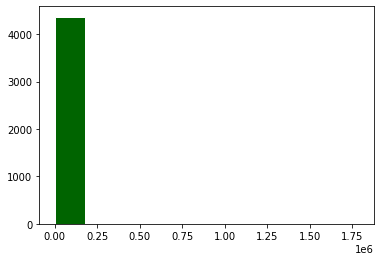

In [17]:
plt.hist(df2.orbitperiod, color = "darkgreen", edgecolor = 'white')

(array([1.100e+01, 4.260e+02, 1.905e+03, 1.158e+03, 4.170e+02, 3.240e+02,
        1.140e+02, 1.400e+01, 1.000e+00, 1.000e+00]),
 array([-2.40012857, -0.7203431 ,  0.95944238,  2.63922785,  4.31901333,
         5.9987988 ,  7.67858428,  9.35836975, 11.03815523, 12.7179407 ,
        14.39772618]),
 <BarContainer object of 10 artists>)

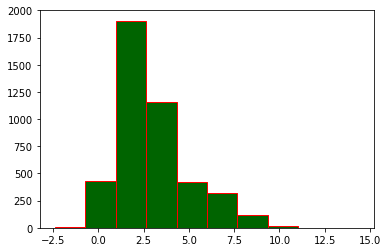

In [18]:
orbper_log = np.log(orbper)
plt.hist(orbper_log, color = "darkgreen", edgecolor = 'red')

The orbital period is skewed right, but after applying a log transform, the distribution more closely resembles a Gaussian distribution.

Going add 10 to every element in the array so as to be able to perform Log Transform on the eccentricity dataset as well.

(array([3437.,  366.,  238.,  121.,   76.,   49.,   34.,   22.,   16.,
          12.]),
 array([2.30258509, 2.31149493, 2.32040476, 2.3293146 , 2.33822443,
        2.34713427, 2.3560441 , 2.36495394, 2.37386377, 2.38277361,
        2.39168344]),
 <BarContainer object of 10 artists>)

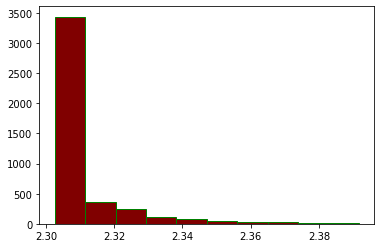

In [19]:
eccen_2 = eccen + 10
eccen_log = np.log(eccen_2)
plt.hist(eccen_log, color = "maroon", edgecolor = 'green')

The distribution is still skewed right after applying the transform.

#### Model Building

Will implement robust scaling to deal with outliers.

As a resampling method, will use the train-test-split (tts) method. Will bundle the logic of tts into a function.

In [20]:
def tts(data, split = 0.80):
    train = list()
    train_size = split*len(data)
    data_copy = list(data)
    while len(train) < train_size :
        index = randrange(len(data_copy))
        train.append(data_copy.pop(index))
    return np.array(train), np.array(data_copy)

In [21]:
X1_train, X1_test = tts(orbper_log)
#y1_train, y1_test = tts(eccen)
y1_train, y1_test = tts(eccen_log)
#rs = RobustScaler()
#scale_X1_train = rs.fit_transform(X1_train.reshape(-1, 1))
#scale_y1_train = rs.fit_transform(y1_train.reshape(-1, 1))
#scale_X1_test = rs.fit_transform(X1_test.reshape(-1, 1))
#scale_X1_train

In [22]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(np.array(orbper_log), np.array(eccen_log), train_size = 0.80, random_state = 25)


In [23]:
model_knn1 = KNeighborsRegressor(n_neighbors = 27)
model_knn1.fit(X1_train.reshape(-1, 1), y1_train.reshape(-1, 1))
#model_knn1.fit(X1_train.T, y1_train.T)
y_knn_train_pred_1 = model_knn1.predict(X1_train.reshape(-1, 1))
y_knn_test_pred_1 = model_knn1.predict(X1_test.reshape(-1, 1))

In [24]:
# Following line to remind myself that values between 0 - 1 will produce negative value in log.
np.log(0.055550)

-2.890471762896498

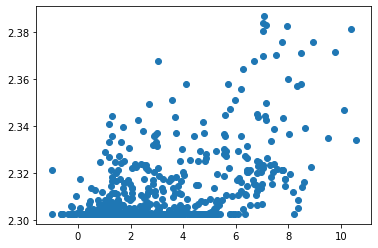

In [25]:
plt.scatter(X1_test, y1_test)

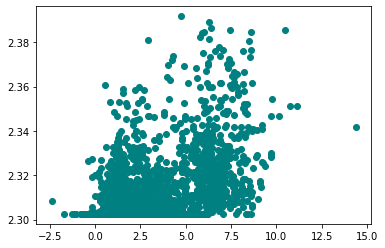

In [26]:
plt.scatter(X1_train, y1_train, c = "teal")

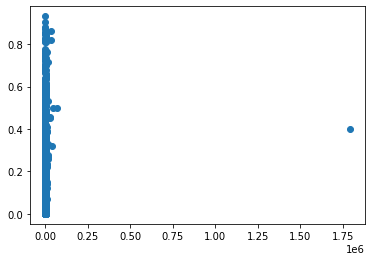

In [27]:
plt.scatter(orbper, eccen)

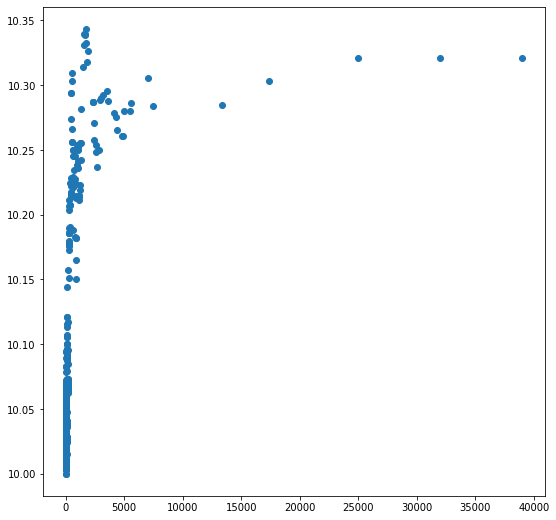

In [28]:
# Following to 'unscale' the fitted data
# The y-values are the actual test data.
inverse_X1test = np.exp(X1_test)
inverse_knn_model_1 = np.exp(y_knn_test_pred_1)
plt.figure(figsize = (9, 9))
#plt.scatter(inverse_X1test, y1_test)
plt.scatter(inverse_X1test, inverse_knn_model_1)

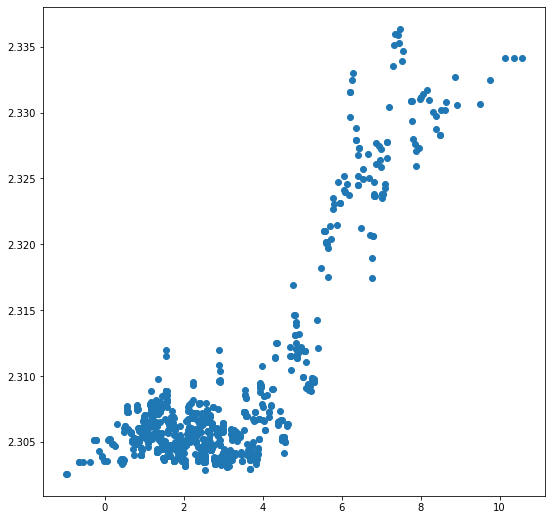

In [29]:
plt.figure(figsize = (9, 9))
plt.scatter(X1_test, y_knn_test_pred_1)
#plt.scatter(inverse_X1test, inverse_knn_model_1)

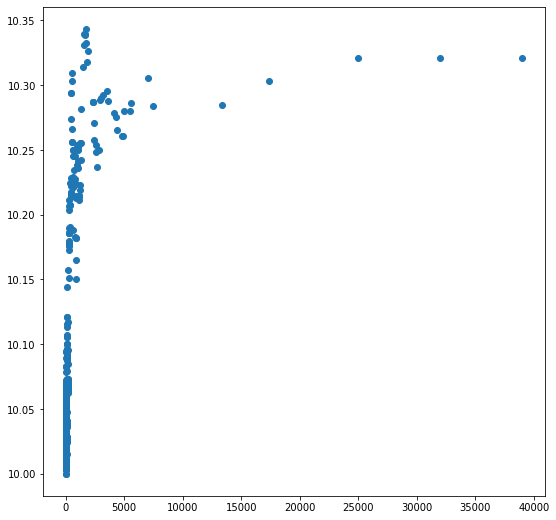

In [30]:
plt.figure(figsize = (9, 9))
plt.scatter(np.exp(X1_test), np.exp(y_knn_test_pred_1))

Want to make a quick calculation of the residuals in this prediction and actual values evaluation.

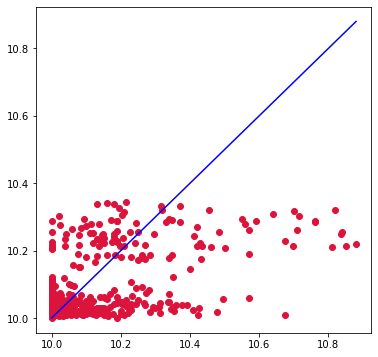

In [31]:
true_values_1 = np.exp(y1_test) 
predicted_values1_1 = np.exp(y_knn_test_pred_1)
plt.figure(figsize = (6, 6))
plt.scatter(true_values_1, predicted_values1_1, c = 'crimson')
p1 = max(max(predicted_values1_1), max(true_values_1))
p2 = min(min(predicted_values1_1), min(true_values_1))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.show()

Want to plot the residuals and see if there are any obvious patterns. Another name is the Versus Fit.

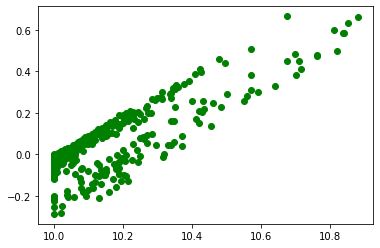

In [32]:
#residuals1_1 = np.subtract(true_values_1, predicted_values1_1)
residuals1_1 = list()
for item1, item2 in zip(true_values_1, predicted_values1_1):
    residuals1_1.append(item1 - item2)
plt.scatter(true_values_1, residuals1_1, c = 'green')

There is an obvious pattern in the residuals plot.

In [33]:
# First the training metrics.
knn1_train_mse = mean_squared_error(y1_train, y_knn_train_pred_1)
knn1_train_r2 = r2_score(y1_train, y_knn_train_pred_1)
# Now, test mean square and r2 score.
knn1_test_mse = mean_squared_error(y1_test, y_knn_test_pred_1)
knn1_test_r2 = r2_score(y1_test, y_knn_test_pred_1)
# Consolidate the results.
knn_results_1 = pd.DataFrame(['k Nearest Neighbor', knn1_train_mse, knn1_train_r2, knn1_test_mse, knn1_test_r2]).transpose()
#results_1 = pd.DataFrame(columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2'])
#results1 = pd.DataFrame()
#results_1 = pd.concat([results1, knn_results_1], axis=1)
#results_1.append(knn_results_1, ignore_index=True)
metric_col_names = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
knn_results_1.columns = metric_col_names
print(knn_results_1)
#knn_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
#print(knn_results)

               Method Training MSE Training R2  Test MSE   Test R2
0  k Nearest Neighbor     0.000113    0.332674  0.000122  0.350379


In [34]:
knn_results_1

,Method,Training MSE,Training R2,Test MSE,Test R2
0,k Nearest Neighbor,0.000113,0.332674,0.000122,0.350379


In [35]:
# NB: the independent variable is orbital period (X)
# dependent variable is ecentricity (y)
#X2_train, X2_test = tts(orbper)
#y2_train, y2_test = tts(eccen)
#X2_train, y2_train = pd.DataFrame(X2_train), pd.DataFrame(y2_train)
#X2_test, y2_test = pd.DataFrame(X2_test), pd.DataFrame(y2_test)
#test_set_1 = pd.concat([X2_test, y2_test], axis = 1)
#train_set_1 = pd.concat([X2_train, y2_train], axis = 1)
#df2_scaled = pd.DataFrame(rs.fit_transform(df2_scaled), columns = df2_scaled.columns, index = df2_scaled.index)
#df2_scaled.head()

In [36]:
model_knn1

KNeighborsRegressor(n_neighbors=27)

Now, will use the SVR for regressor model.

In [37]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X1_train.reshape(-1, 1), y1_train.reshape(-1, 1))
y_svr_train_pred = regressor.predict(X1_train.reshape(-1, 1))
y_svr_test_pred = regressor.predict(X1_test.reshape(-1, 1))
# Model performance
svr_train_mse = mean_squared_error(X1_train.reshape(-1, 1), y_svr_train_pred.reshape(-1, 1))
svr_train_r2 = r2_score(X1_train.reshape(-1, 1), y_svr_train_pred.reshape(-1, 1))
# Test results
svr_test_mse = mean_squared_error(X1_test.reshape(-1, 1), y_svr_test_pred.reshape(-1, 1))
svr_test_r2 = r2_score(X1_test.reshape(-1, 1), y_svr_test_pred.reshape(-1, 1))
# Consolidate the results.
#svr_results = pd.DataFrame(['SVR', svr_train_mse, svr_train_r2, svr_test_mse, svr_test_r2]).T
svr_results = pd.DataFrame(['SVR', svr_train_mse, svr_train_r2, svr_test_mse, svr_test_r2]).T
svr_results.columns = metric_col_names
#results2 = pd.concat([knn_results, svr_results.T], ignore_index = False)
#print(results2)
print(svr_results)

  Method Training MSE Training R2 Test MSE   Test R2
0    SVR     4.268436   -0.088707  4.26754 -0.090057


c:\users\joepb\miniconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
results_1 = pd.concat([knn_results_1, svr_results], axis = 0, ignore_index = True)
results_1 

,Method,Training MSE,Training R2,Test MSE,Test R2
0,k Nearest Neighbor,0.000113,0.332674,0.000122,0.350379
1,SVR,4.268436,-0.088707,4.26754,-0.090057


Now want to model using the Random Forest Regressor.

In [39]:
rf = RandomForestRegressor(max_depth=2)
rf.fit(X1_train.reshape(-1, 1), y1_train.reshape(-1, 1))
y_rf1_train_pred = rf.predict(X1_train.reshape(-1, 1))
y_rf1_test_pred = rf.predict(X1_test.reshape(-1, 1))
print(rf)

C:\Users\joepb\AppData\Local\Temp\ipykernel_4716\3674644462.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X1_train.reshape(-1, 1), y1_train.reshape(-1, 1))


RandomForestRegressor(max_depth=2)


In [40]:
# Model performance metrics for random forest model.
rf_train_1_mse = mean_squared_error(y1_train, y_rf1_train_pred)
rf_train_1_r2 = r2_score(y1_train, y_rf1_train_pred)
rf_test_1_mse = mean_squared_error(y1_test, y_rf1_test_pred)
rf_test_1_r2 = r2_score(y1_test, y_rf1_test_pred)

In [41]:
rf1_results = pd.DataFrame(['Random Forest', rf_train_1_mse, rf_train_1_r2, rf_test_1_mse, rf_test_1_r2]).transpose()
rf1_results.columns = metric_col_names
print(rf1_results)

          Method Training MSE Training R2  Test MSE   Test R2
0  Random Forest     0.000115    0.322034  0.000118  0.369545


In [42]:
results_1 = pd.concat([results_1, rf1_results], axis = 0, ignore_index = True)
results_1

,Method,Training MSE,Training R2,Test MSE,Test R2
0,k Nearest Neighbor,0.000113,0.332674,0.000122,0.350379
1,SVR,4.268436,-0.088707,4.26754,-0.090057
2,Random Forest,0.000115,0.322034,0.000118,0.369545


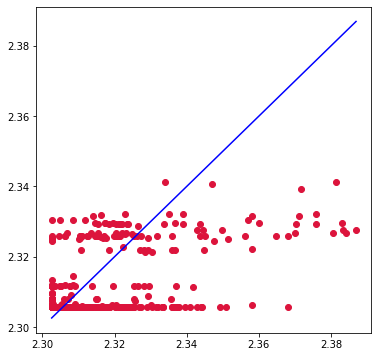

In [43]:
true_values_1 = y1_test
predicted_values1_2 = y_rf1_test_pred
plt.figure(figsize = (6, 6))
plt.scatter(true_values_1, predicted_values1_2, c = 'crimson')
p1 = max(max(predicted_values1_2), max(true_values_1))
p2 = min(min(predicted_values1_2), min(true_values_1))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.show()

Now want to begin analysis of equilibrium temperature as a function of planet size.

In [44]:
df3 = raw_data.loc[:, ['pl_name','pl_bmassj','pl_eqt']]
df3

,pl_name,pl_bmassj,pl_eqt
0,11 Com b,19.40,NaN
1,11 Com b,17.10,NaN
2,11 UMi b,10.80,NaN
3,11 UMi b,14.74,NaN
4,11 UMi b,10.50,NaN
...,...,...,...
32511,ups And d,4.10,NaN
32512,ups And d,10.25,NaN
32513,ups Leo b,0.51,NaN
32514,xi Aql b,2.02,NaN


In [45]:
df3 = df3.rename(columns={'pl_name':'planetname', 'pl_bmassj':'mass', 'pl_eqt':'temperature'})
df3 = df3.dropna()
df3

,planetname,mass,temperature
23,1RXS J160929.1-210524 b,12.00000,1700.0
24,1RXS J160929.1-210524 b,8.00000,1700.0
25,1RXS J160929.1-210524 b,8.00000,1800.0
26,1RXS J160929.1-210524 b,8.00000,1800.0
30,2M0437 b,4.00000,1450.0
...,...,...,...
32454,kap And b,13.61600,1900.0
32473,pi Men c,0.01422,1147.0
32474,pi Men c,0.01517,1170.0
32480,rho CrB b,1.04490,614.0


In [46]:
mass = df3.groupby('planetname')['mass'].mean()
temp = df3.groupby('planetname')['temperature'].mean()

In [47]:
print(mass)
print(temp)

planetname
1RXS J160929.1-210524 b         9.000000
2M0437 b                        4.000000
2MASS J12073346-3932539 b       4.500000
2MASS J21402931+1625183 A b    20.950000
51 Eri b                        2.000000
                                 ...    
bet Pic b                      13.500000
kap And b                      13.208000
pi Men c                        0.014695
rho CrB b                       1.044900
rho CrB c                       0.078660
Name: mass, Length: 860, dtype: float64
planetname
1RXS J160929.1-210524 b        1750.0
2M0437 b                       1450.0
2MASS J12073346-3932539 b      1200.0
2MASS J21402931+1625183 A b    2075.0
51 Eri b                        700.0
                                ...  
bet Pic b                      1631.0
kap And b                      1790.0
pi Men c                       1158.5
rho CrB b                       614.0
rho CrB c                       448.0
Name: temperature, Length: 860, dtype: float64


(array([748.,  54.,  19.,  13.,  10.,   6.,   4.,   3.,   2.,   1.]),
 array([9.1000000e-04, 3.0008190e+00, 6.0007280e+00, 9.0006370e+00,
        1.2000546e+01, 1.5000455e+01, 1.8000364e+01, 2.1000273e+01,
        2.4000182e+01, 2.7000091e+01, 3.0000000e+01]),
 <BarContainer object of 10 artists>)

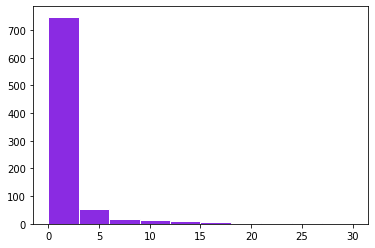

In [48]:
plt.hist(mass, color = "blueviolet", edgecolor = 'white')

(array([  7.,  23.,  77., 132.,  60.,  90., 249., 131.,  61.,  30.]),
 array([-7.00206596, -5.96173962, -4.92141329, -3.88108696, -2.84076062,
        -1.80043429, -0.76010795,  0.28021838,  1.32054471,  2.36087105,
         3.40119738]),
 <BarContainer object of 10 artists>)

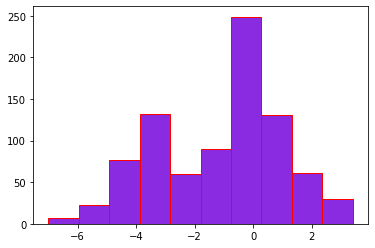

In [49]:
mass_log = np.log(mass)
plt.hist(mass_log, color = "blueviolet", edgecolor = 'red')

(array([100., 172., 182., 214., 128.,  45.,  16.,   0.,   2.,   1.]),
 array([  50.,  450.,  850., 1250., 1650., 2050., 2450., 2850., 3250.,
        3650., 4050.]),
 <BarContainer object of 10 artists>)

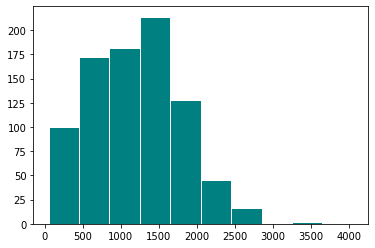

In [50]:
plt.hist(temp, color = "teal", edgecolor = 'white')

(array([  4.,   1.,  10.,  23.,  62., 109., 175., 298., 172.,   6.]),
 array([3.91202301, 4.35146792, 4.79091284, 5.23035775, 5.66980267,
        6.10924758, 6.5486925 , 6.98813741, 7.42758233, 7.86702724,
        8.30647216]),
 <BarContainer object of 10 artists>)

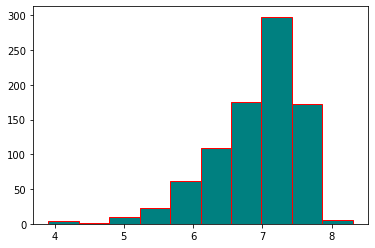

In [51]:
temp_log = np.log(temp)
plt.hist(temp_log, color = "teal", edgecolor = 'red')

In [52]:
X2_train, X2_test = tts(mass_log)
y2_train, y2_test = tts(temp_log)

In [53]:
# kNN R-squared accuracy
knn_r_acc_2 = []
for i2 in range(1, 75, 1):
    knn_2 = KNeighborsRegressor(n_neighbors = i2)
    knn_2.fit(X2_train.reshape(-1, 1), y2_train.reshape(-1, 1))
    test_score_2 = knn_2.score(X2_test.reshape(-1, 1), y2_test.reshape(-1, 1))
    train_score_2 = knn_2.score(X2_train.reshape(-1, 1), y2_train.reshape(-1, 1))
    knn_r_acc_2.append((i2, test_score_2, train_score_2))
outcomes_2 = pd.DataFrame(knn_r_acc_2, columns = ['k', 'Test Score', 'Train Score'])
print(outcomes_2)
print('The highest Test R-squared value occurs at : %.4f' % outcomes_2.iloc[:,1].max())
print('Within given range, optimal k is: ', outcomes_2.loc[outcomes_2['Test Score'] == outcomes_2.iloc[:,1].max(), 'k'].iloc[0])

     k  Test Score  Train Score
0    1   -0.937768     0.783714
1    2   -0.479747     0.511221
2    3   -0.344874     0.371406
3    4   -0.312990     0.291666
4    5   -0.209980     0.248841
..  ..         ...          ...
69  70   -0.025192     0.029495
70  71   -0.025288     0.028231
71  72   -0.022345     0.028540
72  73   -0.021702     0.028763
73  74   -0.021578     0.029968

[74 rows x 3 columns]
The highest Test R-squared value occurs at : -0.0204
Within given range, optimal k is:  65


In [54]:
model_knn_2 = KNeighborsRegressor(n_neighbors = 65)
model_knn_2.fit(X2_train.reshape(-1, 1), y2_train.reshape(-1, 1))
y_knn_train_pred_2 = model_knn_2.predict(X2_train.reshape(-1, 1))
y_knn_test_pred_2 = model_knn_2.predict(X2_test.reshape(-1, 1))

In [55]:
df1_scaled = train_set_1.copy()
df1_scaled.columns = ['orbitperiod', 'eccentricity']
df1_scaled

NameError: name 'train_set_1' is not defined

In [ ]:
y_knn_test_pred2_scaled.shape

In [ ]:
y_knn_test_pred2_scaled[:,0]

In [ ]:
some_array = [df1_scaled[:,0],y_knn_test_pred2_scaled]
y_knn_pred2 = rs.inverse_transform(y_knn_test_pred2_scaled)
y_knn_pred2

In [ ]:
X2_test.shape

In [ ]:
type(X2_test)

In [ ]:
y2_train.shape

In [ ]:
X2_train.shape

In [ ]:
type(X2_train)

In [ ]:
X2_train

In [ ]:
# kNN R-squared accuracy
knn_r_acc = []
for i1 in range(1, 75, 1):
    knn = KNeighborsRegressor(n_neighbors = i1)
    knn.fit(X2_train.reshape(-1, 1), y2_train.reshape(-1, 1))
    test_score = knn.score(X2_test.reshape(-1, 1), y2_test.reshape(-1, 1))
    train_score = knn.score(X2_train.reshape(-1, 1), y2_train.reshape(-1, 1))
    knn_r_acc.append((i1, test_score, train_score))
outcomes = pd.DataFrame(knn_r_acc, columns = ['k', 'Test Score', 'Train Score'])
print(outcomes)
print('The highest Test R-squared value occurs at : %.4f' % outcomes.iloc[:,1].max())
print('Within given range, optimal k is: ', outcomes.loc[outcomes['Test Score'] == outcomes.iloc[:,1].max(), 'k'].iloc[0])

Notice that the above block of code determines optimal k for kNN without the use of scaling. I did this same algorithm after scaling and the R-squared values obtained were incosistent.

In [ ]:
training_scaled = [X2_train, y2_train]
train_x_scale = rs.transform(training_scaled)
rs1_1 = RobustScaler().fit(X2_train.reshape(-1, 1))
rs1_2 = RobustScaler().fit(y2_train.reshape(-1, 1))
rs1_3 = RobustScaler().fit(X2_test.reshape(-1, 1))
rs1_4 = RobustScaler().fit(y2_test.reshape(-1, 1))
# Transformer1 is the x2 train scaled data, and transformer 2 is the y2 training data scaled.
# Similar logic for the testing data sets.
x2_train_scale = rs1_1.transform(X2_train.reshape(-1, 1))
y2_train_scale = rs1_2.transform(y2_train.reshape(-1, 1))
x2_test_scale = rs1_3.transform(X2_test.reshape(-1, 1))
y2_test_scale = rs1_4.transform(y2_test.reshape(-1, 1))

In [ ]:
x2_train_scale

In [ ]:
x2_train_scale.shape

In [ ]:
type(x2_train_scale)

In [ ]:
x2_train_scale

In [ ]:
# kNN R-squared accuracy
knn_r_acc = []
for i in range(1, 75, 1):
    knn = KNeighborsRegressor(n_neighbors = i)
    knn.fit(x2_train_scale, y2_train_scale)
    test_score = knn.score(x2_test_scale, y2_test_scale)
    train_score = knn.score(x2_train_scale, y2_train_scale)
    knn_r_acc.append((i, test_score, train_score))
outcomes = pd.DataFrame(knn_r_acc, columns = ['k', 'Test Score', 'Train Score'])
print(outcomes)
print('The highest Test R-squared value occurs at : %.4f' % outcomes.iloc[:,1].max())
print('Within given range, optimal k is: ', outcomes.loc[outcomes['Test Score'] == outcomes.iloc[:,1].max(), 'k'].iloc[0])

In [ ]:
knn_model_2 = KNeighborsRegressor(n_neighbors = 59)
knn_model_2.fit(x2_train_scale, y2_train_scale)
y_knn_train_pred2_scaled = knn_model_2.predict(x2_train_scale)
y_knn_test_pred2_scaled = knn_model_2.predict(x2_test_scale)

In [ ]:
y_knn_test_pred2_scaled

In [ ]:
y_knn_test_pred2_scaled.shape

In [ ]:
type(y_knn_test_pred2_scaled)

In [ ]:
y_knn_test_pred2_scaled.ndim

In [ ]:
y_knn_pred2 = rs1_3.inverse_transform(y_knn_test_pred2_scaled)
y_knn_pred2

In [ ]:
r2_score(x2_test_scale, y_knn_test_pred2_scaled)

In [ ]:
plt.scatter(y2_test, y_knn_pred2)

In [ ]:
#X1 = df2_scaled[['orbitperiod']]
#y1 = df2_scaled[['eccentricity']]
X1 = transformer[:,0]
y1 = transformer[:,1]
X1_train, X1_test = tts(X1)
y1_train, y1_test = tts(y1)
X1_train, y1_train = pd.DataFrame(X1_train), pd.DataFrame(y1_train)
X1_test, y1_test = pd.DataFrame(X1_test), pd.DataFrame(y1_test)
print('\nTraining X1 shape: ', X1_train.shape)
print('Training y1 shape: ', y1_train.shape)
print('Test X1 shape: ', X1_test.shape)
print('Test y1 shape: ', y1_test.shape)

In [ ]:
y2_test.head()

In [ ]:
knn_model_2 = KNeighborsRegressor(n_neighbors = 68)
knn_model_2.fit(transformer1[:,0], transformer1[:,1])
y_knn_train_pred2_scaled = knn_model_2.predict(transformer1[:,1])
y_knn_test_pred2_scaled = knn_model_2.predict(transformer2[:,0])

Will run kNN for various values of n_neighbors and store results. This will help me determine optimal 'k'.

In [ ]:
# kNN R-squared accuracy
knn_r_acc = []
for i in range(1, 75, 1):
    knn = KNeighborsRegressor(n_neighbors = i)
    knn.fit(X1_train, y1_train)
    test_score = knn.score(X1_test, y1_test)
    train_score = knn.score(X1_train, y1_train)
    knn_r_acc.append((i, test_score, train_score))
outcomes = pd.DataFrame(knn_r_acc, columns = ['k', 'Test Score', 'Train Score'])
print(outcomes)
print('The highest Test R-squared value occurs at : %.4f' % outcomes.iloc[:,1].max())
print('Within given range, optimal k is: ', outcomes.loc[outcomes['Test Score'] == outcomes.iloc[:,1].max(), 'k'].iloc[0])

Logic above details optimal k for building model.
Will now create the kNN model.

In [ ]:
knn_model_1 = KNeighborsRegressor(n_neighbors = 68)
knn_model_1.fit(X1_train, y1_train)
y_knn_train_pred1_scaled = knn_model_1.predict(X1_train)
y_knn_test_pred1_scaled = knn_model_1.predict(X1_test)

In [ ]:
y_knn_train_pred1_scaled.shape 

In [ ]:
scaled_pred = np.array(y_knn_test_pred1_scaled)
scaled_pred

In [ ]:
scaled_pred.shape

In [ ]:
scaled_pred.ndim

In [ ]:
transformer.shape

In [ ]:
y_knn_test_pred1_scaled

In [ ]:
#some_array = np.array([X1_test, y_knn_test_pred1_scaled])
some_array = np.append(X1_test, y_knn_test_pred1_scaled, 1)
type(some_array)

In [ ]:
some_array.shape

In [ ]:
some_array

In [ ]:
some_array[:,0]

In [ ]:
z = rs.inverse_transform(transformer)
scaled_testdata = np.append(X1_test, y1_test, 1)
z1 = rs.inverse_transform(scaled_testdata)
z1

In [ ]:
z1.shape

In [ ]:
z1[:,1]

In [ ]:
y_knn_pred1.shape

In [ ]:
y_knn_pred1 = rs.inverse_transform(some_array)
#y_knn_pred1 = rs.inverse_transform(y_knn_test_pred1_scaled)

In [ ]:
print(y_knn_pred1)

In [ ]:
y_knn_pred1[:,1]

In [ ]:
plt.scatter(z1[:,1], y_knn_pred1[:,1])
plt(axis='equal)')

In [ ]:
y_knn_test_pred1_scaled.shape 

In [ ]:
len(df2_scaled)

In [ ]:
print(y_knn_train_pred1_scaled.ravel)

In [ ]:
df3 = pd.DataFrame(scaled_data)
df3.hist()

In [ ]:
df3

The next section of code will use Robust Scaling to properly scale the dataframe. I want to use the kNN supervised learning model, but it is distance based and thus sensitive to scale of the data points.

In [ ]:
# Generate random predictions.
def random_algorithm(train, test):
    #output_values = [row[-1] for row in train]
    output_values = [row[-1] for row in train]
    unique = list(set(output_values))
    predicted = list()
    for row in test:
        index = randrange(len(unique))
        predicted.append(unique[index])
    return predicted

In [ ]:
def the_real_random_algo(train_list, test_list):
    predicted = []
    for row in test_list:
        index = randrange(len(train_list))
        predicted.append(train_list[index])
    return predicted

For regression problem, the mean of the target (dependent variable) values can serve as a good baseline.

In [56]:
#y_pred = y_train.mean()
y_pred = y.mean() # <- this method is probably best practice as opposed to line above.
y_pred

NameError: name 'y' is not defined

In [ ]:
x6.orbitperiod.mean()

In [ ]:
y_pred2 = [y_pred] * len(y_train)
y_pred2

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Error for training data baseline guess.
mean_abs_err = mean_absolute_error(y_train, y_pred2)
mean_abs_err

So MAE is 0.6799 so the models we work with want to have a lower MAE

In [ ]:
# Mean squared error for training data baseline guess.
mean_sqrd = mean_squared_error(y_train, y_pred2)
mean_sqrd

So our mean squared error is 0.8305.

Now want to obtian metric for test data set.


In [ ]:
# Prediction for y_test
y_pred3 = [y_pred] * len(y_test)
y_pred3
# Mean absolute error for test data
mae = mean_absolute_error(y_test, y_pred3)
# Mean squared error for test data
mse = mean_squared_error(y_test, y_pred3)
print(f'mae: {mae} \nMSE: {mse}')

Notice MAE for test data is slightly lower than MAE for training data.
i.e. 0.626 < 0.678

In [ ]:
y_test_r2 = r2_score(y_test, y_pred3)
print(f'Test Set R2: {y_test_r2}')

In [ ]:
plt.scatter(X, y, c = 'crimson')

In [ ]:
# Test the function above against the previous data.
#predictions = random_algorithm([x_train], [x_test])
predictions = the_real_random_algo(list2, list3)
predictions0 = the_real_random_algo([x_train, y_train], [x_test, y_test])
predictions02 = the_real_random_algo(y_train, y_test)
print(predictions0)
print(len(predictions0))
print((predictions02))

In [ ]:
#predictions01 = the_real_random_algo(x_train, x_test)
#some_mse = mean_squared_error(y_test, predictions0)
#print(some_mse)

In [ ]:
# Will name the performance metrics for the prediction set as "some" so as to imply generality.
#some_mse = mean_squared_error(y_train,predictions02)
#some_r2 = r2_score(w2_train, y_svr_train_pred)

Did calculations on the training and testing lists before converting them to a dataframe.

In [ ]:
x_train, y_train = pd.DataFrame(x_train), pd.DataFrame(y_train)
x_test, y_test = pd.DataFrame(x_test), pd.DataFrame(y_test)
print('\nTraining x shape: ', x_train.shape)
print('Training y shape: ', y_train.shape)
print('Test x shape: ', x_test.shape)
print('Test y shape: ', y_test.shape)

Want to establish a baseline to compare to the ML model against. Will create a funciton using the Random Prediction Algorithm.

In [ ]:
knn_r_acc = []
for j in range(1, 60, 1):
    knn = KNeighborsRegressor(n_neighbors = j)
    knn.fit(x_train, y_train)
    
    test_score = knn.score(x_test, y_test)
    train_score = knn.score(x_train, y_train)
    
    knn_r_acc.append((j, test_score, train_score))
   
results = pd.DataFrame(knn_r_acc, columns = ['k', 'Test Score', 'Train Score'])
print(results)
print(results.iloc[:,1].max())
print(results.loc[results['Test Score'] == results.iloc[:,1].max(), 'k'].iloc[0])

According to the results above, k = 29 seems to be the best k. What is concerning is that I feel if I extended the 'for' loop to a higher value, perhaps I would see a better performing k value.

Now, by adjusting the range of for loop to 45, found the optimal k to be k = 40.

Will now create the kNN model.

In [ ]:
model_knn = KNeighborsRegressor(n_neighbors = 40)
model_knn.fit(x_train, y_train)
y_knn_train_pred = model_knn.predict(x_train)
y_knn_test_pred = model_knn.predict(x_test)

For model performace, first the training mean square error and R2 score.

In [ ]:
knn_train_mse = mean_squared_error(y_train, y_knn_train_pred)
knn_train_r2 = r2_score(y_train, y_knn_train_pred)
# Now, test mean square and r2 score.
knn_test_mse = mean_squared_error(y_test, y_knn_test_pred)
knn_test_r2 = r2_score(y_test, y_knn_test_pred)
# Consolidate the results.
knn_results = pd.DataFrame(['k Nearest Neighbor', knn_train_mse, knn_train_r2, knn_test_mse, knn_test_r2]).transpose()
#results1 = pd.DataFrame(columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2'])
results1 = pd.DataFrame()
results1 = pd.concat([results1, knn_results])
print(results1)
#knn_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
#print(knn_results)

In [ ]:
len(y_knn_test_pred)

In [ ]:
len(y_test)

In [ ]:
g = plt.plot(true_values - predicted_values, marker = 'o', linestyle = '')

In [ ]:
#from yellowbrick.regressor import prediction_error
#model = Lasso()
#visualizer = prediciton_error(model, x_train, y_train, x_test, y_test)

In [ ]:
#Set plot size
#plt.subplots(figsize=(10,5))
#Set X-Axis range
#plt.xlim(min(true_values), max(true_values))
#plt.title('Model Error Distribution')
#plt.ylabel('No. of Predictions')
#plt.xlabel('Error')
#plt.hist(predictions['error'], bins=np.linspace(min(test_values), max(test_values), num=41, dtype=int));
#plt.show()

In [ ]:
residuals = true_values - predicted_values
plt.scatter(true_values, residuals)


There is an obvious positive linear relationship which indicates that the kNN model is not best supervised learning model for this data.

In [ ]:
w1 = x6.iloc[:, 0:1].values
w2 = x6.iloc[:, 1:2].values
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
w3 = sc_X.fit_transform(w1)
w4 = sc_y.fit_transform(w2)
w1_train, w1_test = tts(w3)
w2_train, w2_test = tts(w4)

In [ ]:
print(len(w1_train))
print(len(w1))
print(len(w1_test))

In [ ]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(w1_train, w2_train)
y_svr_train_pred = regressor.predict(w1_train)
y_svr_test_pred = regressor.predict(w1_test)
# Model performance
svr_train_mse = mean_squared_error(w2_train, y_svr_train_pred)
svr_train_r2 = r2_score(w2_train, y_svr_train_pred)
# Test results
svr_test_mse = mean_squared_error(w2_test, y_svr_test_pred)
svr_test_r2 = r2_score(w2_test, y_svr_test_pred)
# Consolidate the results.
#svr_results = pd.DataFrame(['SVR', svr_train_mse, svr_train_r2, svr_test_mse, svr_test_r2]).T
svr_results = pd.DataFrame(['SVR', svr_train_mse, svr_train_r2, svr_test_mse, svr_test_r2])
#results2 = pd.concat([knn_results, svr_results.T], ignore_index = False)
#print(results2)

In [ ]:
results2 = pd.concat([knn_results,svr_results.T], ignore_index = True)
results2.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
results2

Now want to compute confidence intervals as a standard practice while computing metrics.

Will compare the R-squared value for kNN and Random Forest models.

In [ ]:
from sklearn.utils import resample
def r2_ci(test_data): # The function will be set up for a 95% confidence interval.
    bootstrap_iter = 1000
    sample_size = 10000
    #sample_size = bootstrap_iter
    r2_metrics = []
    confidence = 0.95
    alpha_level = 0.95 * 100
    lower = ((1.0 - confidence)/2.0) * 100 # Should be 2.5 as the lower bound.
    upper = alpha_level + (((1.0 - confidence)/2.0) * 100) # Should be 97.5 as the upper bound
    for i in range(bootstrap_iter):
        sample = resample(predictions, n_samples = sample_size)
        #r2 = r2_score(test_data, predictions)
        r2 = r2_score(test_data, sample)
        r2_metrics.append(r2)
    confidence_interval = np.percentile(r2_metrics, [lower, upper])
    return confidence_interval

In [ ]:
95 + (((1.0 - 0.95)/2.0) * 100)

In [ ]:
#r2_ci(y_test, y_knn_test_pred)

In [ ]:
(0.95*100)+((1.0-.95)/2.0)*100

Will now study the relationship between planet mass and temperature.

In [ ]:
path3 = 'D:\\PS_2022.04.14_19.39.14.csv'
#path3 = 'E:\\PS_2022.04.14_19.39.14.csv'
raw_data2 = pd.read_csv(path3, skiprows = 28) #  <- notice had to skip first 29 lines.

In [ ]:
print(raw_data2)
raw_data2.columns

In [ ]:
type(raw_data2) #<- already a pandas data frame.

In [ ]:
df4 = raw_data2.loc[:, ['pl_name','pl_bmassj','pl_eqt']]
df4.reset_index(drop=True, inplace=True)

In [ ]:
df4

In [ ]:
df4 = df4.rename(columns={'pl_name':'planetname','pl_bmassj':'planetmass', 'pl_eqt':'temperature'})
df4 = df4.dropna()

In [ ]:
df4

In [ ]:
print(type(df4.iloc[0][1]))
print(type(df4.iloc[0][2]))

Notice both of the above are float data type which will make computation easier.

In [ ]:
df4.reset_index(drop=True, inplace=True)

In [ ]:
df4

In [ ]:
x7 = df4.groupby('planetname')['planetmass'].mean()
x8 = df4.groupby('planetname')['temperature'].mean()
x8

In [ ]:
df5 = pd.concat([x7, x8], axis = 1)
df5

In [ ]:
mass = df5['planetmass']
temp = df5['temperature']
mass_med = statistics.median(list(mass))
temp_med = statistics.median(list(temp))
print('\nThe median of the planet mass: %.2f' % mass_med)
print('\nThe median of the temperature: %.2f' % temp_med)
iqr_mass = stats.iqr(mass, interpolation = 'midpoint')
iqr_temp = stats.iqr(temp, interpolation = 'midpoint')
print('\nThe interquartile range of the planet mass: %.2f' % iqr_mass)
print('\nThe interquartile range of the temperature: %.2f' % iqr_temp)
print(statistics.mean(list(mass)))

In [ ]:
plt.hist(df5.planetmass, density = True, color = "darkorange")

In [ ]:
plt.hist(df5.temperature, color = "navy")

Note that the trend in this distribution is not as skewed as the other metrics. That is, it more closely resembles a normal distribution.

In [ ]:
x9 = df5[['planetmass', 'temperature']]

In [ ]:
x9

In [ ]:
rs2 = RobustScaler().fit(x9)
transformer2 = rs2.transform(x9)
print(type(transformer2))
len(transformer2)

In [ ]:
x10 = transformer2[:, 0]
y2 = transformer2[:, 1]

In [ ]:
x_train2, x_test2 = tts(x10)
y_train2, y_test2 = tts(y2)

In [ ]:
type(x_train2)

In [ ]:
plt.scatter(x9.planetmass, x9.temperature, c = 'darkorange')

Need to convert the above from Pandas dataframes to numpy ndarrays for the Random Prediction Algorithm.

In [ ]:
#x_train2.to_numpy
#x_test2.to_numpy
#y_train2.to_numpy
#y_test2.to_numpy

In [ ]:
#predictions2 = random_algorithm([x_train2], [x_test2])
predictions2 = the_real_random_algo(y_train2, y_test2)
#predictions2 = random_algorithm([x_train2, y_train2], [x_test2, y_test2])
print(predictions2)

In [ ]:
x_train2, y_train2 = pd.DataFrame(x_train2), pd.DataFrame(y_train2)
x_test2, y_test2 = pd.DataFrame(x_test2), pd.DataFrame(y_test2)
print('\nTraining x2 shape: ', x_train2.shape)
print('Training y2 shape: ', y_train2.shape)
print('Test x2 shape: ', x_test2.shape)
print('Test y2 shape: ', y_test2.shape)

In [ ]:
knn_r_acc2 = []
for n in range(1, 60, 1):
    knn2 = KNeighborsRegressor(n_neighbors = n)
    knn2.fit(x_train2, y_train2)
    
    test_score2 = knn2.score(x_test2, y_test2)
    train_score2 = knn2.score(x_train2, y_train2)
    
    knn_r_acc2.append((n, test_score2, train_score2))
   
outcome = pd.DataFrame(knn_r_acc2, columns = ['k', 'Test Score', 'Train Score'])
print(outcome)
print(outcome.iloc[:,1].max())

The maximum test score for this kNN model occurs when k = 15.
Will not create the second kNN model to help describe the relationship betweeen mass and temperature.

In [ ]:
model_knn2 = KNeighborsRegressor(n_neighbors = 15)
model_knn2.fit(x_train2, y_train2)
y_knn_train_pred2 = model_knn2.predict(x_train2)
y_knn_test_pred2 = model_knn2.predict(x_test2)

In [ ]:
knn_train_mse_2 = mean_squared_error(y_train2, y_knn_train_pred2)
knn_train_r2_2 = r2_score(y_train2, y_knn_train_pred2)
# Now, test mean square and r2 score.
knn_test_mse_2 = mean_squared_error(y_test2, y_knn_test_pred2)
knn_test_r2_2 = r2_score(y_test2, y_knn_test_pred2)
# Consolidate the results.
knn_results2 = pd.DataFrame(['k Nearest Neighbor', knn_train_mse_2, knn_train_r2_2, knn_test_mse_2, knn_test_r2_2]).transpose()
results3 = pd.DataFrame()
results3 = pd.concat([results3, knn_results2])
print(results2)

In [ ]:
true_values2 = y_test2
predicted_values2 = y_knn_test_pred2
plot2 = plt.figure(figsize=(8,8))
plot2 =plt.scatter(true_values2, predicted_values2, c = 'lime')

residuals2 = true_values2 - predicted_values2
plot2 = plt.scatter(true_values2, residuals2)

plt.axis('equal')
plt.show(plot2)

In [ ]:
residuals2.shape

Notice no pattern so model does describe the data.

In [ ]:
w5 = x9.iloc[:, 0:1].values
w6 = x9.iloc[:, 1:2].values
sc2_X = StandardScaler()
sc2_y = StandardScaler()
w7 = sc2_X.fit_transform(w5)
w8 = sc2_y.fit_transform(w6)
w3_train, w3_test = tts(w7)
w4_train, w4_test = tts(w7)

In [ ]:
type(w3_train)

In [ ]:
regressor2 = SVR(kernel = 'rbf')
regressor2.fit(w3_train, w4_train)
y_svr_train_pred2 = regressor2.predict(w3_train)
y_svr_test_pred2 = regressor2.predict(w3_test)
# Model performance
svr_train_mse_2 = mean_squared_error(w4_train, y_svr_train_pred2)
svr_train_r2_2 = r2_score(w4_train, y_svr_train_pred2)
# Test results
svr_test_mse_2 = mean_squared_error(w4_test, y_svr_test_pred2)
svr_test_r2_2 = r2_score(w4_test, y_svr_test_pred2)
# Consolidate the results.
#svr_results = pd.DataFrame(['SVR', svr_train_mse, svr_train_r2, svr_test_mse, svr_test_r2]).T
svr_results2 = pd.DataFrame(['SVR', svr_train_mse_2, svr_train_r2_2, svr_test_mse_2, svr_test_r2_2])
#results2 = pd.concat([knn_results, svr_results.T], ignore_index = False)
#print(results2)

In [ ]:
results3 = pd.concat([knn_results2,svr_results.T], ignore_index = True)
results3.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
results3

Now to add the Random Forest Regressor.

In [ ]:
rf2 = RandomForestRegressor(max_depth=2)
rf2.fit(w3_train, w4_train)
y_rf_train_pred2 = rf2.predict(w3_train)
y_rf_test_pred2 = rf2.predict(w3_test)

In [ ]:
some_prediction = random_algorithm(w3_train, w3_test)
print(some_prediction)

In [ ]:
some_r2 = r2_score(w3_test, some_prediction)
print(some_r2)

In [ ]:
# Model performance metrics for random forest model.
rf2_train_mse = mean_squared_error(w4_train, y_rf_train_pred2)
rf2_train_r2 = r2_score(w4_train, y_rf_train_pred2)
rf2_test_mse = mean_squared_error(w4_test, y_rf_test_pred2)
rf2_test_r2 = r2_score(w4_test, y_rf_test_pred2)

In [ ]:
rf_results2 = pd.DataFrame(['Random Forest', rf2_train_mse, rf2_train_r2, rf2_test_mse, rf2_test_r2]).transpose()
rf_results2.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']

In [ ]:
results3 = pd.concat([results3, rf_results2], ignore_index = True)
results3

Random Forest model seems to be the best performing of the trio in this scenario. Still need to do further exploraiton of the interpretation of the R2 value.

In [ ]:
rf2_rmse = sqrt(rf2_test_mse)
print('The Random Forest 2 model RMSE is: ', rf2_rmse)